In [25]:
import zipfile
import pandas as pd
import movie_utils
from tqdm import tqdm, trange
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# data from: https://grouplens.org/datasets/movielens/

files = {}

with zipfile.ZipFile("ml-32m.zip", 'r') as zip:
    zip_contents = zip.namelist()
    for file_name in zip_contents:
        if file_name.endswith('.csv'):
            print("Downloading " + file_name + "...")
            with zip.open(file_name) as file:
                df = pd.read_csv(file)
                files[file_name[7:-4]] = df

In [42]:
files["links"] = files["links"][["movieId", "tmdbId"]]
files["links"].head()

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0


In [43]:
files["ratings"] = files["ratings"][["userId", "movieId", "rating"]]
files["ratings"].head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0


In [44]:
files["movies"] = files["movies"].merge(files["links"], left_on="movieId", right_on="movieId", how="inner")
files["movies"].head()

,movieId,title,genres,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,31357.0
4,5,Father of the Bride Part II (1995),Comedy,11862.0


In [45]:
movies = {}

for movie in files["movies"].iterrows():
    movie = movie[1]
    movies[movie.movieId] = movie_utils.Movie(movie.movieId, movie.tmdbId, movie.title, movie.genres)

In [46]:
user = files["ratings"][files["ratings"]["userId"] == 2024][:5]
for movie in user.iterrows():
    if movie[1].movieId in movies.keys():
        print("-----------------------------------------------------------------------------------------------")
        print(movies[movie[1].movieId])
        print("Rating: " + str(movie[1].rating))

-----------------------------------------------------------------------------------------------
Clerks 	1994
Comedy
Rating: 1.0
-----------------------------------------------------------------------------------------------
Exotica 	1994
Drama
Rating: 2.0
-----------------------------------------------------------------------------------------------
Red Firecracker, Green Firecracker (Pao Da Shuang Deng) 	1994
Drama
Rating: 1.0
-----------------------------------------------------------------------------------------------
Maltese Falcon, The 	1941
Film-Noir | Mystery
Rating: 5.0
-----------------------------------------------------------------------------------------------
Gone with the Wind 	1939
Drama | Romance | War
Rating: 5.0


In [ ]:
popular_movies = files["ratings"][["movieId", "userId"]].groupby("movieId").count()
popular_movies = popular_movies.sort_values(by=["userId"], ascending=False)
popular_movies = popular_movies.index.values.tolist()

num_movies = 1000
top_popular_movies = set(popular_movies[:num_movies])

In [ ]:
total = len(files["ratings"])
ratings = np.empty((total, 3), dtype=np.float32)

i = 0
for rating in tqdm(files["ratings"].iterrows(), total=total):
    if rating[1].movieId in top_popular_movies:
        ratings[i, 0] = rating[1].userId
        ratings[i, 1] = rating[1].movieId
        ratings[i, 2] = rating[1].rating
        i += 1

ratings = ratings[:i]
np.savez_compressed("ratings.npz", ratings=ratings)

100%|██████████| 32000204/32000204 [31:23<00:00, 16992.68it/s]


In [5]:
ratings = np.load("ratings.npz")["ratings"]

In [6]:
ratings_df = pd.DataFrame(ratings, columns=["userId", "movieId", "rating"], index=[i for i in range(len(ratings))])
ratings_df["userId"] = ratings_df["userId"].astype(int)
ratings_df["movieId"] = ratings_df["movieId"].astype(int)
ratings_df.head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,32,5.0
4,1,34,2.0


In [7]:
ratings_df = ratings_df.pivot_table(index="userId", columns="movieId", values="rating")
ratings_df

movieId,1,2,3,5,6,7,10,11,16,17,...,168252,171763,174055,176371,177765,187593,195159,202439,204698,207313
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.5,NaN,NaN,NaN,NaN,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200944,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200946,NaN,NaN,NaN,NaN,4.0,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
def isvt(X, r, max_iter=500, epsilon=1e-2):
    # Create a mask for the known entries in X
    mask = X > 0  
    prevM = np.zeros(X.shape)
    prevM[mask] = X[mask]

    progress_bar = trange(max_iter)
    
    for _ in progress_bar:
        currM = np.copy(prevM)
        
        # Perform Singular Value Decomposition
        U, S, Vt = svds(currM, k=r) # Threshold by only calculating the top r singular values
        currM = U @ np.diag(S) @ Vt

        # Fill in known values in currM from X
        currM[mask] = X[mask]
        
        # Check for convergence
        norm = np.linalg.norm(currM - prevM, ord='fro') / np.linalg.norm(prevM, ord='fro')
        if norm < epsilon:
            break
            
        progress_bar.set_description(f"[{r=:}, {norm=:.3e}]")
        
        prevM = currM
    
    return currM

In [102]:
def train_test_split(df, p):
    # Flatten the DataFrame to get all values with their index positions
    all_values = [(i, j, value) for i, row in df.iterrows() for j, value in row.items() if value > 0]

    # Calculate the number of values to pick based on the percentage
    num_values_to_pick = int(p * len(all_values))

    # Randomly pick the specified number of values
    test_values = random.sample(all_values, num_values_to_pick)

   # Create a copy of the DataFrame to modify
    new_df = df.copy()

    # Replace the picked values in the new DataFrame with 0
    for i, j, _ in test_values:
        new_df.at[i, j] = 0

    return new_df, test_values

def isvt_with_score(X, r, test_proportion=0.1, max_iter=500, epsilon=1e-2):
    # create train / test split 
    train_df, test_values = train_test_split(X, test_proportion)

    # run isvt algorithm with given rank
    M = isvt(train_df.to_numpy(), r=r, max_iter=max_iter, epsilon=epsilon)
    M = pd.DataFrame(M, columns=train_df.columns, index=train_df.index)

    # compare predicted values with expected ones
    scores = np.array([abs(rating - M.at[i, j]) for i, j, rating in test_values])
    avg_error = scores.mean()

    return (M, avg_error)

def cross_val_isvt(X, r_list, test_proportion=0.1, plot=True, max_iter=500, epsilon=1e-2):
    # calculate the error for each rank in r_list
    errors = [] 
    for r in r_list:
        errors.append(isvt_with_score(X, r, test_proportion, max_iter, epsilon))

    if plot:
        plt.plot(r_list, [err for _, err in errors])
        plt.xlabel("rank")
        plt.ylabel("error")

    # find the rank with the lowest error
    best = np.argmin(np.array([err for _, err in errors]))
    return (errors[best][0], r_list[best])

[r=64, norm=1.002e-03]:  45%|████▍     | 223/500 [15:59<19:52,  4.30s/it]


Rank: 8


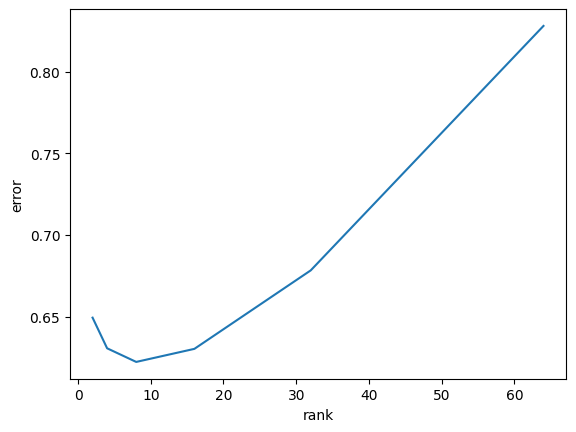

In [100]:
num_users = 50000
X = ratings_df[:num_users]
bestM = cross_val_isvt(X, r_list=[2**n for n in range(1,7)])
print(f"Rank: {bestM[1]}")

In [103]:
M, error = isvt_with_score(X, bestM[1], epsilon=1e-4)

[r=8, norm=4.275e-04]: 100%|██████████| 500/500 [12:52<00:00,  1.54s/it]


In [105]:
M

movieId,1,2,3,5,6,7,10,11,16,17,...,168252,171763,174055,176371,177765,187593,195159,202439,204698,207313
userId,,,,,,,,,,,,,,,,,,,,,
1,3.311354,1.909161,0.931470,0.925938,2.690909,1.380532,2.141991,1.764792,2.786867,4.000000,...,3.144043,2.543814,3.084234,3.409882,3.046522,2.376741,3.662825,3.208405,2.575980,2.985987
2,4.482643,4.477016,4.888729,5.174443,2.879436,5.631654,3.782790,5.389195,2.460928,5.413382,...,0.872015,0.587374,-0.020645,-0.492522,1.304467,1.021472,0.995783,-0.168974,0.690543,0.614984
3,3.642018,3.500000,3.249780,3.488037,3.469116,3.945076,4.000000,4.000000,3.124125,4.028986,...,4.537343,4.245616,4.588397,4.056916,4.641200,4.230871,4.779900,4.054315,4.138004,4.567842
4,3.317904,1.829028,1.380263,0.902927,2.388955,1.191179,2.550554,1.680395,2.527738,1.982748,...,-1.800536,-2.959673,-2.245364,-1.419650,-1.717059,-2.503091,-1.752207,-2.158824,-2.279151,-2.109545
5,3.237688,3.645716,3.496671,3.348067,2.676979,3.202206,4.000000,3.286566,2.411277,2.354093,...,1.163953,0.828587,0.046848,0.085331,0.609146,1.482186,0.995779,0.060433,0.991959,0.582886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50009,2.531823,1.500000,2.162611,2.492793,3.102951,3.217318,1.711684,3.500000,3.000132,4.423934,...,2.595263,3.007902,3.603338,3.117259,3.399145,2.061544,2.839218,3.763534,3.282406,3.363314
50010,3.922694,3.658998,4.046162,4.366386,2.096018,5.000000,3.334348,4.864141,1.598564,5.000000,...,1.120746,0.194907,0.616636,-0.060479,1.803867,0.866049,1.335331,-0.496968,0.109350,0.869024
50011,2.572877,2.282563,0.023440,-0.012474,2.959972,-0.396876,2.259681,0.365479,2.669269,-0.063832,...,3.500000,3.809569,3.500000,3.500000,3.164554,4.000000,3.583497,3.917537,3.895750,3.732408
